In [1]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import layers, models, Input, callbacks, regularizers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

#-----------------------
#---configs so I don't have to search and change values at 10 different places in the script everytime I want to change smtg
#---(lesson learnt the hard way)
#-----------------------
class Config:
    # --- Paths ---
    H5_PATH = "/kaggle/input/aspcapstar-dr17-150kstars/apogee_dr17_parallel.h5" 
    TFREC_DIR = "/kaggle/working/tfrecords"
    STATS_PATH = "/kaggle/working/dataset_stats.npz"
    
    # --- System ---
    TESTING_MODE = True
    TEST_LIMIT = 20000 
    NUM_SHARDS = 16 
    
    # --- Model Hyperparameters ---
    BATCH_SIZE = 512       
    LEARNING_RATE = 2e-4   
    EPOCHS = 100
    LATENT_DIM = 268
    OUTPUT_LENGTH = 8575
    
    # --loss related---
    L2_VAL = 1e-4          
    INPUT_NOISE = 0.05     
    IVAR_SCALE = 1000.0   
    CLIP_NORM = 1.0        

    #----predictor-labels--------
    SELECTED_LABELS = [
        # 1. Core
        'TEFF', 'LOGG', 'FE_H', 'VMICRO', 'VMACRO', 'VSINI',
        # 2. CNO
        'C_FE', 'N_FE', 'O_FE',
        #3. metals
        'MG_FE', 'SI_FE', 'CA_FE', 'TI_FE', 'S_FE',
        'AL_FE', 'MN_FE', 'NI_FE', 'CR_FE' 
    ]

config = Config()
os.makedirs(config.TFREC_DIR, exist_ok=True)

2026-01-16 13:04:39.381585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768568679.795636      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768568679.897226      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768568680.899992      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768568680.900039      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768568680.900042      24 computation_placer.cc:177] computation placer alr

In [2]:
def get_nans(h5_path, selected_labels):
    """
    Scans the dataset and prints the percentage of unusable (NaN/Flagged) 
    data for each label.
    """
    print(f"Scanning {len(selected_labels)} labels for missing data...")
    print(f"{'LABEL':<10} | {'MISSING %':<10} | {'STATUS'}")
    
    missing_report = {}
    
    with h5py.File(h5_path, 'r') as f:
        # Detect structure (Group vs Table)
        if isinstance(f['metadata'], h5py.Group):
            get_col = lambda k: f['metadata'][k][:]
            keys = list(f['metadata'].keys())
        else:
            get_col = lambda k: f['metadata'][k]
            keys = f['metadata'].dtype.names

        # Get total count from the first label
        total_stars = len(get_col(selected_labels[0]))
        
        for label in selected_labels:
            # 1. Get Raw Values
            raw_vals = get_col(label)
            
            # 2. Check Flags (The Robust Logic)
            flag_name = f"{label}_FLAG"
            if flag_name in keys:
                flg = get_col(flag_name)
                # Handle Void/Structured types
                if flg.dtype.names: flg = flg[flg.dtype.names[0]]
                if flg.dtype.kind == 'V': flg = flg.view('<i4')
                
                # Bad if Flag != 0
                is_bad_flag = (flg.astype(int) != 0)
            else:
                is_bad_flag = np.zeros(total_stars, dtype=bool)
                
            # 3. Check Placeholder Values (Standard APOGEE -9999)
            # We check < -100 to catch any weird negative placeholders
            is_bad_val = (raw_vals < -100)
            
            # 4. Combine (Either Flagged OR Missing Value)
            total_bad = np.logical_or(is_bad_flag, is_bad_val)
            
            # 5. Calculate Stats
            bad_count = np.sum(total_bad)
            pct = (bad_count / total_stars) * 100
            missing_report[label] = pct
            
            # 6. Status Indicator
            if pct < 5.0:
                status = "Great"
            elif pct < 20.0:
                status = "Okay"
            else:
                status = "Hell Nah"
            
            print(f"{label:<10} | {pct:>9.2f}% | {status}")

    print("-" * 50)
    return missing_report


In [3]:
#==================================

def get_clean_imputed_data(h5_path, selected_labels, limit=None):
    
    print("Read data for imputation")
    
    with h5py.File(h5_path, 'r') as f:
        # Detect structure type
        if isinstance(f['metadata'], h5py.Group):
            get_col = lambda k: f['metadata'][k][:]
            keys = list(f['metadata'].keys())
        else:
            get_col = lambda k: f['metadata'][k]
            keys = f['metadata'].dtype.names

        raw_values = np.stack([get_col(p) for p in selected_labels], axis=1)
        bad_mask = np.zeros_like(raw_values, dtype=bool)
        
        for i, label in enumerate(selected_labels):
            flag_name = f"{label}_FLAG"
            if flag_name in keys:
                flg = get_col(flag_name)
                # FIX: Handle Void/Structured Types safely
                if flg.dtype.names: flg = flg[flg.dtype.names[0]]
                if flg.dtype.kind == 'V': flg = flg.view('<i4')
                is_bad = (flg.astype(int) != 0)
            elif label in ['TEFF', 'LOGG', 'VMICRO', 'VMACRO', 'VSINI']:
                is_bad = (raw_values[:, i] < -5000)
            else:
                is_bad = np.zeros_like(raw_values[:, i], dtype=bool)
            bad_mask[:, i] = is_bad

    if limit:
        print(f"⚠️ Truncating to first {limit} stars.")
        raw_values = raw_values[:limit]
        bad_mask = bad_mask[:limit]

    print(f"   🚀 Imputing Labels for {len(raw_values)} stars...")
    vals_to_impute = raw_values.copy()
    vals_to_impute[bad_mask] = np.nan
    
    imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, initial_strategy='median')
    clean_labels = imputer.fit_transform(vals_to_impute)
    return clean_labels

def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def generate_tfrecords():
    """Converts H5 to TFRecords (Runs once)."""
    print(f"🚀 Starting TFRecord Generation (Shards: {config.NUM_SHARDS})...")
    limit = config.TEST_LIMIT if config.TESTING_MODE else None
    
    # 1. Clean Labels
    clean_labels = get_clean_imputed_data(config.H5_PATH, config.SELECTED_LABELS, limit=limit)
    
    # 2. Save Stats
    mean_labels = np.mean(clean_labels, axis=0)
    std_labels = np.std(clean_labels, axis=0)
    std_labels[std_labels == 0] = 1.0 
    np.savez(config.STATS_PATH, mean=mean_labels, std=std_labels)
    print(f"✅ Stats saved to {config.STATS_PATH}")
    
    # 3. Write Shards
    total_stars = len(clean_labels)
    shard_size = int(np.ceil(total_stars / config.NUM_SHARDS))
    
    with h5py.File(config.H5_PATH, 'r') as f:
        ds_flux = f['flux']
        ds_ivar = f['ivar']
        
        for shard_id in range(config.NUM_SHARDS):
            start_idx = shard_id * shard_size
            end_idx = min((shard_id + 1) * shard_size, total_stars)
            if start_idx >= total_stars: break
            
            filename = os.path.join(config.TFREC_DIR, f"data_{shard_id:02d}.tfrec")
            print(f"   Writing Shard {shard_id+1}/{config.NUM_SHARDS}: {filename}")
            
            with tf.io.TFRecordWriter(filename) as writer:
                chunk_flux = ds_flux[start_idx:end_idx]
                chunk_ivar = ds_ivar[start_idx:end_idx]
                chunk_labels = clean_labels[start_idx:end_idx]
                
                for i in range(len(chunk_labels)):
                    label_bytes = tf.io.serialize_tensor(chunk_labels[i].astype(np.float32))
                    spec_raw = np.stack([chunk_flux[i], chunk_ivar[i]], axis=-1).astype(np.float32)
                    spec_bytes = tf.io.serialize_tensor(spec_raw)
                    
                    feature = {'labels': _bytes_feature(label_bytes), 'spectra': _bytes_feature(spec_bytes)}
                    writer.write(tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString())
    print("✅ TFRecord Generation Complete.")

# Generate if missing
if not glob.glob(os.path.join(config.TFREC_DIR, "*.tfrec")):
    generate_tfrecords()
else:
    print("✅ TFRecords found. Skipping generation.")

🚀 Starting TFRecord Generation (Shards: 16)...
Read data for imputation
⚠️ Truncating to first 20000 stars.
   🚀 Imputing Labels for 20000 stars...
✅ Stats saved to /kaggle/working/dataset_stats.npz
   Writing Shard 1/16: /kaggle/working/tfrecords/data_00.tfrec


I0000 00:00:1768568726.742605      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Writing Shard 2/16: /kaggle/working/tfrecords/data_01.tfrec
   Writing Shard 3/16: /kaggle/working/tfrecords/data_02.tfrec
   Writing Shard 4/16: /kaggle/working/tfrecords/data_03.tfrec
   Writing Shard 5/16: /kaggle/working/tfrecords/data_04.tfrec
   Writing Shard 6/16: /kaggle/working/tfrecords/data_05.tfrec
   Writing Shard 7/16: /kaggle/working/tfrecords/data_06.tfrec
   Writing Shard 8/16: /kaggle/working/tfrecords/data_07.tfrec
   Writing Shard 9/16: /kaggle/working/tfrecords/data_08.tfrec
   Writing Shard 10/16: /kaggle/working/tfrecords/data_09.tfrec
   Writing Shard 11/16: /kaggle/working/tfrecords/data_10.tfrec
   Writing Shard 12/16: /kaggle/working/tfrecords/data_11.tfrec
   Writing Shard 13/16: /kaggle/working/tfrecords/data_12.tfrec
   Writing Shard 14/16: /kaggle/working/tfrecords/data_13.tfrec
   Writing Shard 15/16: /kaggle/working/tfrecords/data_14.tfrec
   Writing Shard 16/16: /kaggle/working/tfrecords/data_15.tfrec
✅ TFRecord Generation Complete.


In [4]:
# Load Stats
stats = np.load(config.STATS_PATH)
MEAN_TENSOR = tf.constant(stats['mean'], dtype=tf.float32)
STD_TENSOR = tf.constant(stats['std'], dtype=tf.float32)

# ==========================================
 
# ==========================================
def parse_and_normalize(example_proto):
    feature_desc = {
        'labels': tf.io.FixedLenFeature([], tf.string),
        'spectra': tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_desc)
    labels = tf.io.parse_tensor(parsed['labels'], out_type=tf.float32)
    spectra = tf.io.parse_tensor(parsed['spectra'], out_type=tf.float32)
    
    labels.set_shape([len(config.SELECTED_LABELS)])
    spectra.set_shape([config.OUTPUT_LENGTH, 2])
    
    norm_labels = (labels - MEAN_TENSOR) / STD_TENSOR
    return norm_labels, spectra

def build_dataset():
    all_files = sorted(tf.io.gfile.glob(os.path.join(config.TFREC_DIR, "*.tfrec")))
    split_idx = int(len(all_files) * 0.8)
    if split_idx == len(all_files): split_idx -= 1
    
    train_files = all_files[:split_idx]
    val_files = all_files[split_idx:]
    print(f"Data Split: {len(train_files)} Train Files, {len(val_files)} Val Files")
    
    def load_files(filenames):
        ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
        ds = ds.map(parse_and_normalize, num_parallel_calls=tf.data.AUTOTUNE)
        return ds
    
    train_ds = load_files(train_files).shuffle(10000).batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds = load_files(val_files).batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds

train_ds, val_ds = build_dataset()

Data Split: 12 Train Files, 4 Val Files


In [5]:
# ==========================================
# Use a modiefied soblev loss function (I read in a paper it works well)
# ==========================================

@register_keras_serializable()
def sobolev_loss(y_true, y_pred):
    real_flux = y_true[:, :, 0:1]
    ivar = y_true[:, :, 1:2]
    valid_mask = tf.cast(real_flux > -10.0, tf.float32)    
    safe_flux = tf.where(valid_mask == 1.0, real_flux, y_pred)
    ivar_safe = tf.clip_by_value(ivar / 1000.0, 0.0, 1.0)# scale and clip
    ROI=tf.cast(tf.where(safe_flux<0.6,10.0,1),dtype=tf.float32) # weaker spectral lines
    ROI2 =tf.cast(tf.where(safe_flux<0.3,5.0,1),dtype=tf.float32) #strong spectral lines
    weight=tf.where(((safe_flux<0.9) & (ivar>0)),tf.maximum(ivar_safe,tf.cast(1.0,dtype=tf.float32)),ivar_safe)
    #chi2
    mse_term = tf.square(safe_flux - y_pred) * weight * valid_mask*ROI*ROI2
    
    # calculate "gradients" (difference between adjacent pixels)
    true_grad = safe_flux[:, 1:, :] - safe_flux[:, :-1, :]
    pred_grad = y_pred[:, 1:, :] - y_pred[:, :-1, :]
    
    # Calculate Squared Error of gradients (sobolev loss term)
    grad_sq_diff = tf.square(true_grad - pred_grad)
    grad_mask = valid_mask[:, 1:, :] * valid_mask[:, :-1, :]
    grad_trust = (weight[:, 1:, :] * weight[:, :-1, :])
    # Apply mask to gradient loss
    grad_loss = grad_sq_diff * grad_mask * grad_trust
    
    #pad last pixel
    grad_loss = tf.pad(grad_loss, [[0,0], [0,1], [0,0]])
    
    # final loss
    total_loss = (mse_term + (10.0 * grad_loss))
    
    #safety check
    loss = tf.where(tf.math.is_finite(total_loss), total_loss, tf.zeros_like(total_loss))
    
    return tf.reduce_mean(loss)

In [6]:
#scaled the sigmoid function so my model can actually predict 1.0 and 0.0
# most probably  there are better ways to do this, but I don't know any

@register_keras_serializable()
def scaled_sigmoid(x):
    return 1.3 * tf.nn.sigmoid(x)-0.15


def build_model():
    input_dim = len(config.SELECTED_LABELS)
    inputs = Input(shape=(input_dim,))
    #Adding guassian noise just in case my model fits too well (:clown face:)
    #x = layers.GaussianNoise(config.INPUT_NOISE)(inputs)
    x=inputs
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(config.L2_VAL))(x)
    
    #268*32 IS 8576 , very close to our output shape (8575)
    x = layers.Dense(config.LATENT_DIM * 32, activation='relu',\
                     kernel_regularizer=regularizers.l2(config.L2_VAL))(x) # punish extreme weights
    x = layers.Reshape((config.LATENT_DIM, 32))(x)
    
    #Progessively sharpen the image
    filters = [64, 32, 32, 16, 16]
    kernels = [7,  7,  5,  5,  3]

    #residual blocks
    for f, k in zip(filters, kernels):
        x = layers.UpSampling1D(size=2)(x)
        res = layers.Conv1D(f, 1, padding='same', kernel_regularizer=regularizers.l2(config.L2_VAL))(x)
        x = layers.Conv1D(f, kernel_size=k, padding='same', kernel_regularizer=regularizers.l2(config.L2_VAL))(x)
        x = layers.Activation('relu')(x)
        x = layers.SpatialDropout1D(0.1)(x) #avoid overfitting
        x = layers.Add()([x, res])

    #final layer (crop the last pixel so output shape becomes 8575)
    x = layers.Conv1D(1, kernel_size=3, padding='same', activation=scaled_sigmoid)(x)
    outputs = layers.Cropping1D(cropping=(0, 1))(x)
    
    return models.Model(inputs, outputs, name="Spectrogram_Emulator")

In [7]:
#-----------------------
#     TRAIN THE MODEL
#-----------------------
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(config.LEARNING_RATE, clipnorm=config.CLIP_NORM), 
              loss=sobolev_loss)

callbacks_list = [
    callbacks.ModelCheckpoint('best_emulator.keras', save_best_only=True, monitor='val_loss'),
    callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=1, factor=0.5, min_lr=1e-6, verbose=1)
]

print("BEGIN TRAINING")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

BEGIN TRAINING
Epoch 1/100


I0000 00:00:1768568782.533786      65 service.cc:152] XLA service 0x7cac244195f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768568782.533834      65 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768568784.020414      65 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-16 13:06:39.645759: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv.41 = (f32[32,16,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,1,4288]{3,2,1,0} %bitcast.22340, f32[16,512,1,4288]{3,2,1,0} %bitcast.22349), window={size=1x4288}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/Spectrogram_Emulator_1/conv1d_6_1/convolution/Conv2DBackpropFilter" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_confi

     29/Unknown 88s 1s/step - loss: 0.2859

2026-01-16 13:07:55.050016: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv.42 = (f32[16,16,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,152,1,8576]{3,2,1,0} %bitcast.22533, f32[16,152,1,8576]{3,2,1,0} %bitcast.22540), window={size=1x8576 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/Spectrogram_Emulator_1/conv1d_9_1/convolution/Conv2DBackpropFilter" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-01-16 13:07:55.563769: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.513909086s
Trying algorit

     30/Unknown 106s 2s/step - loss: 0.2850

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - loss: 0.2842 - val_loss: 0.2363 - learning_rate: 2.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.2310 - val_loss: 0.2209 - learning_rate: 2.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.2152 - val_loss: 0.2117 - learning_rate: 2.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.2090 - val_loss: 0.2052 - learning_rate: 2.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.2019 - val_loss: 0.2004 - learning_rate: 2.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.1967 - val_loss: 0.1966 - learning_rate: 2.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.1922 - val_loss: 0.1937 - learning_rate: 2.0000e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.1887 - val_loss: 0.1918 - learning_rate: 2.0000e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.1840 - val_loss: 0.1896 - learning_rate: 2.000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/tmp/ipykernel_24/129761372.py:79: RuntimeWarning: divide by zero encountered in log
  ax3.plot(wavelengths,np.log(ivar)-10,color='red',linewidth=0.8)


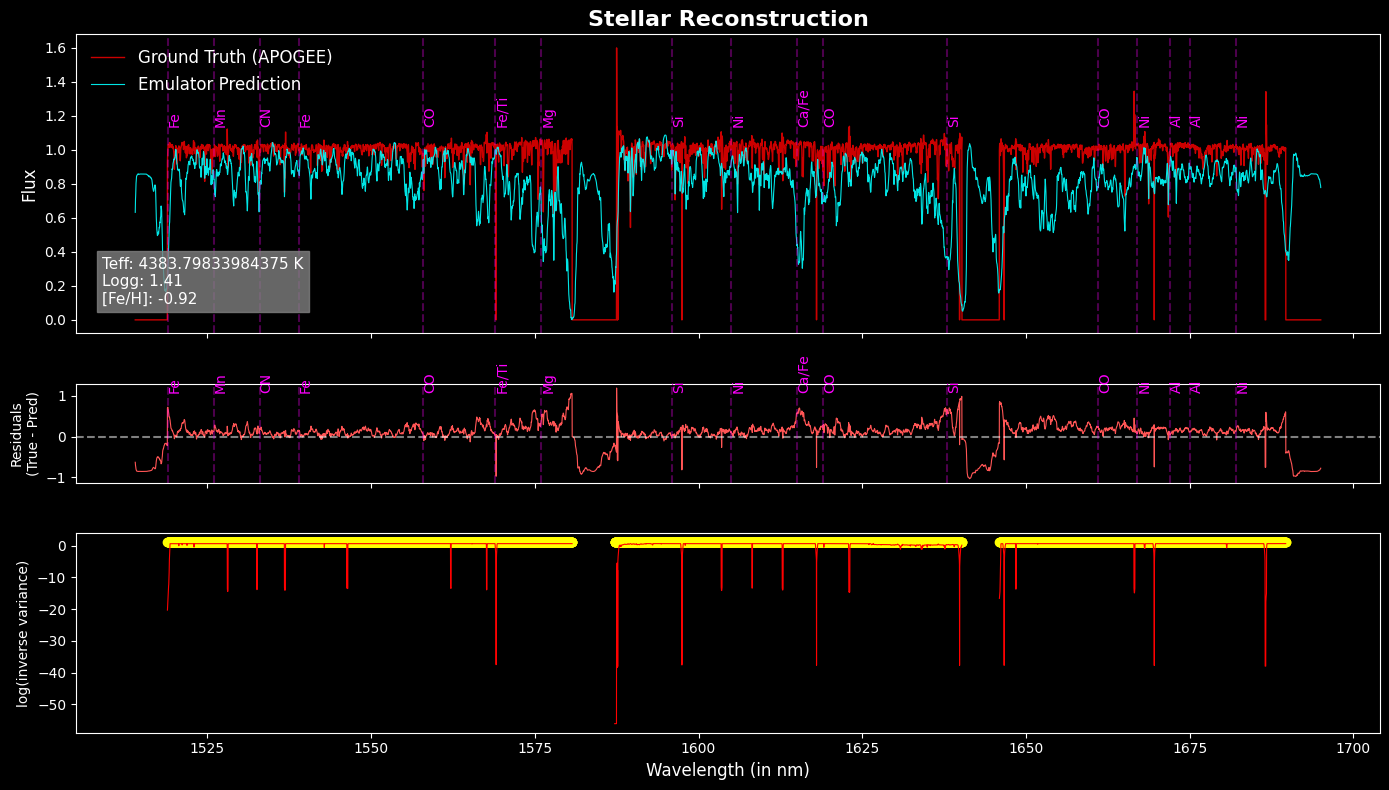

In [8]:

#----SAVE AND PREDICT-----

import matplotlib.pyplot as plt

model=tf.keras.models.load_model('best_emulator.keras')
model.save('SPECTROGRAM_GENERATOR.keras')



def plot_spectrum_comparison(y_true, y_pred,ivar=None, labels=None, title="Stellar Reconstruction"):
    plt.style.use('dark_background') #dark mode >>>>>> 
    wavelengths=np.logspace(np.log10(1514),np.log10(1695),config.OUTPUT_LENGTH)
    # APOGEE takes log wavelengths to space their pixels
    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, figsize=(14, 8), 
        gridspec_kw={'height_ratios': [3, 1,2]}, 
        sharex=True
    )
    
    
    #TOP= SPECTROGRAMS   
    ax1.plot(wavelengths, y_true, color='red', alpha=0.8, linewidth=1, label='Ground Truth (APOGEE)')
    ax1.plot(wavelengths, y_pred, color='cyan', alpha=0.9, linewidth=0.8, label='Emulator Prediction')
    ax1.set_ylabel("Flux", fontsize=12, color='white')
    ax1.set_title(title, fontsize=16, fontweight='bold', color='white')
    ax1.legend(frameon=False, fontsize=12)

    
    #Strong spectral lines that can be seen in stars collected from APOGEE
    # AI generated, couldn't bother looking it up myself (I'll do it later)
    lines = [
        # --- Iron Peak & Core Elements ---
        (1519, "Fe"),     # Strong Iron anchor
        (1526, "Mn"),     # Manganese (Deep Line Driver)
        (1539, "Fe"),     # Strong Iron
        (1569, "Fe/Ti"),  # Strong blend
        (1576, "Mg"),     # Magnesium Triplet Center (The "Big One")
        (1605, "Ni"),     # Nickel (Deep Line Driver)
        (1615, "Ca/Fe"),  # Calcium & Iron
        (1667, "Ni"),     # Nickel
        (1682, "Ni"),     # Nickel

        # --- Alpha Elements ---
        (1596, "Si"),     # Silicon (Very distinctive dip)
        (1638, "Si"),     # Silicon
        (1672, "Al"),     # Aluminum (The "Deepest" single line usually)

        # --- Molecular Bandheads (The "Continuum Shapers") ---
        (1533, "CN"),     # Cyanogen band
        (1558, "CO"),     # Carbon Monoxide Bandhead (Start of 'sawtooth')
        (1619, "CO"),     # CO Bandhead
        (1661, "CO"), 
        (1675, "Al"),# CO Bandhead (Very strong in cool stars)
    ]
    
    for wl, name in lines:
        ax1.axvline(x=wl, color='magenta', alpha=0.3, linestyle='--')
        ax1.text(wl, 1.15, name, color='magenta', rotation=90, fontsize=10)
        
    #BOTTOM=RESIDUALS
    #compare how well the model fits the data
    residuals = y_true - y_pred
    ax2.plot(wavelengths, residuals, color='#FF5555', linewidth=0.8)
    ax2.axhline(0, color='white', linestyle='--', alpha=0.5)
    ax2.set_ylabel("Residuals\n(True - Pred)", fontsize=10)
    
    
    for wl, name in lines:
        ax2.axvline(x=wl, color='magenta', alpha=0.3, linestyle='--')
        ax2.text(wl, 1.15, name, color='magenta', rotation=90, fontsize=10)
    #ax2.set_ylim(-0.2, 0.2) => hopefully my model fits good enough for me to do this (it didn't ;-;)
    
    # show imp labels
    if labels is not None:
        info_str = f"Teff: {labels[0]} K\nLogg: {labels[1]:.2f}\n[Fe/H]: {labels[2]:.2f}"
        ax1.text(0.02, 0.1, info_str, transform=ax1.transAxes, 
                 bbox=dict(facecolor='grey', alpha=0.8, edgecolor='gray'),
                 fontsize=11, color='white')
    ax3.plot(wavelengths,np.log(ivar)-10,color='red',linewidth=0.8)
    ax3.set_ylabel("log(inverse variance)",fontsize=10)
    ax3.set_xlabel("Wavelength (in nm)", fontsize=12)
    s_gap=wavelengths[ivar>0]
    ax3.scatter(s_gap,np.ones_like(s_gap),color='yellow')
    fig.tight_layout() 
    fig.savefig("/kaggle/working/spectrogram_1.jpg")
    fig.show()

#generate sample spectrograms
for batch_labels, batch_spectra in val_ds.take(1):
   
    preds = model.predict(batch_labels)

    idx = 4
    true_spec = batch_spectra[idx, :, 0] 
    ivar=batch_spectra[idx,:,1]
    pred_spec = preds[idx, :, 0]
    star_labels = batch_labels[idx]
    star_labels=star_labels*STD_TENSOR+MEAN_TENSOR
    plot_spectrum_comparison(true_spec, pred_spec,ivar, labels=star_labels)
    break